# Домашнее задание «Элементарные методы анализа временных рядов»

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. 
Оценить качество и прислать соображения почему была выбрана та или иная модель

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales_of_company_x = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/TimeSeries/1._Лекция/Series/daily-total-female-births-in-cal.csv")

In [3]:
all_time_series = {
    "Monthly sales of company X": sales_of_company_x['Count'],
    "Monthly Boston armed robberies": robberies_in_boston['Count'],
    "International airline passengers": airlines_passengers['Count'],
    "Mean monthly air temperature degree": mean_monthly_temp['Deg'],
    "Weekly closings of the dowjones": dowjones_closing['Close'],
    "Daily total female births in cal": female_births['Count']
}

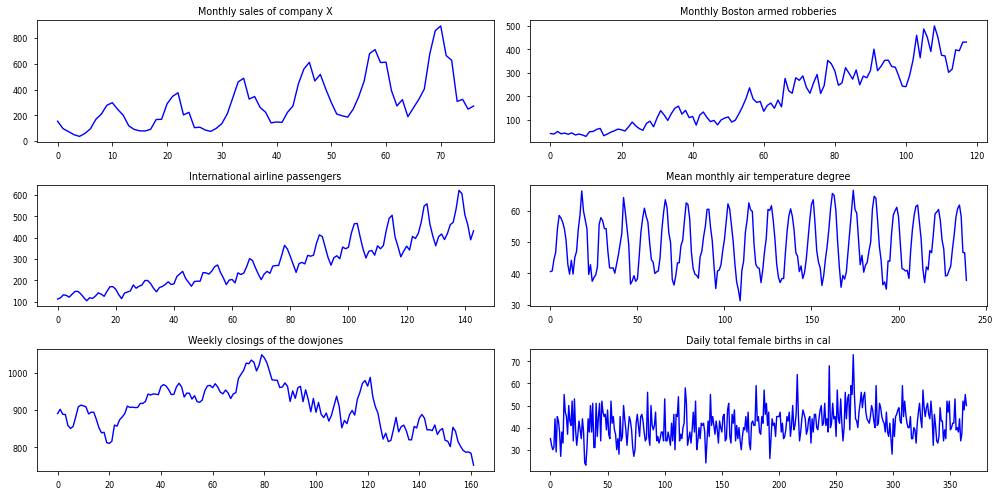

In [4]:
with plt.style.context('seaborn-paper'):
    plt.figure(figsize=(14, 7))
    layout = (3, 2)
    for i, key in enumerate(all_time_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_time_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()
        

# Приблизим модель на данных Monthly Boston armed robberies

Стационарный ряд. Нужно исключить тренд, который имеется в временном ряде.

In [7]:
changed_ts = boxcox(robberies_in_boston['Count'], 0)

In [8]:
changed_ts = changed_ts[1:] - changed_ts[:-1]

In [9]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [10]:
ser = moving_average(changed_ts, 10)

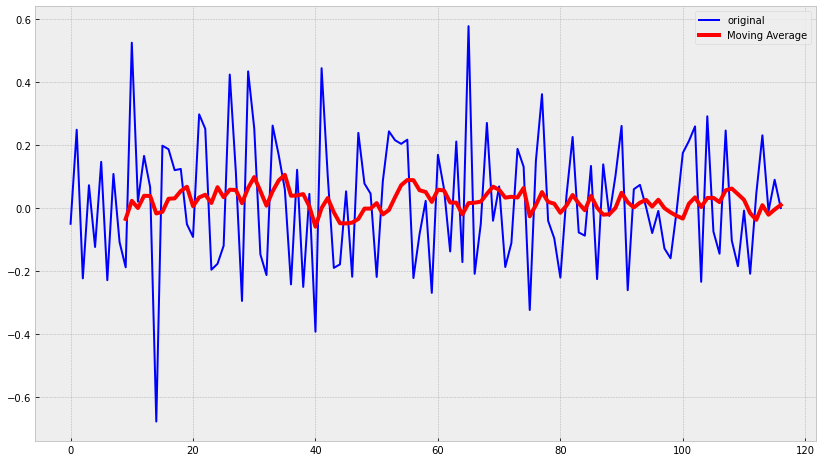

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(changed_ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [96]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [100]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [101]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [102]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [103]:
def plot_tema(alpha, beta, gamma, ser=changed_ts, ser_to_plot=changed_ts, n_preds=30):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

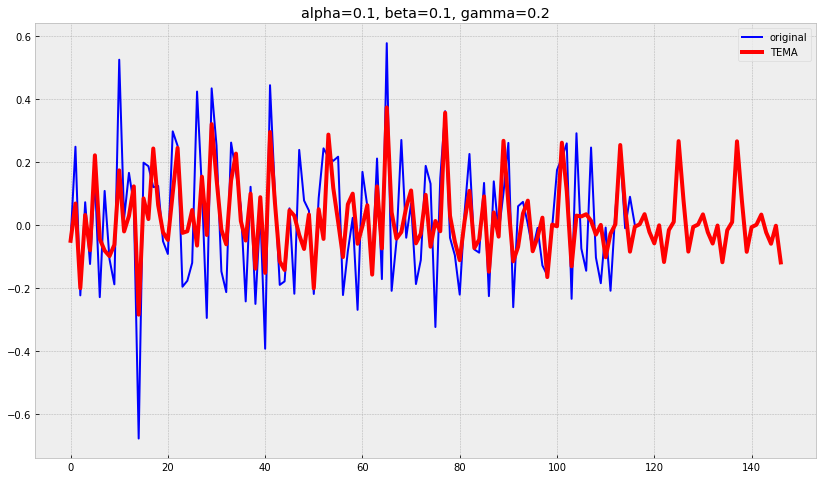

In [104]:
plot_tema(0.1, 0.1, 0.2)

In [99]:
train, val, test = changed_ts[:80], changed_ts[80:90], changed_ts[90:]

In [105]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [106]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [107]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.04382304691458441
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.52863833e-06, -2.41959230e-06,  6.39974182e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 120
      nit: 22
     njev: 30
   status: 0
  success: True
        x: array([0.07959196, 0.04254701, 0.51256834])


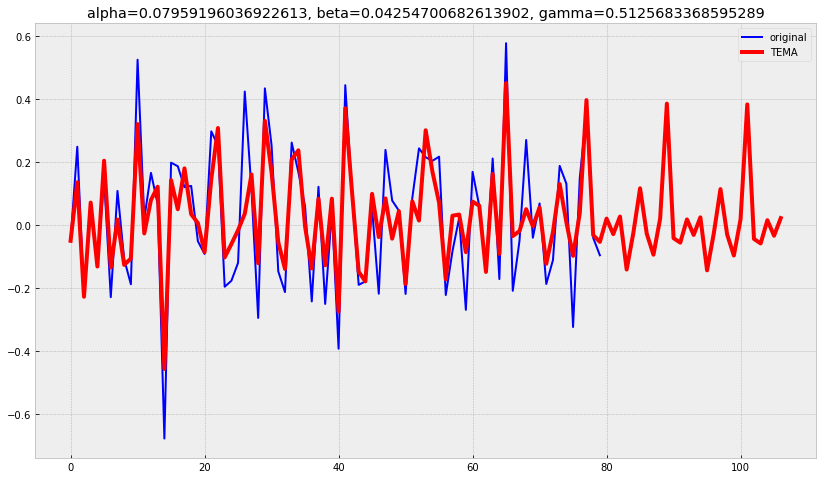

In [109]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=changed_ts[:80], n_preds=len(test))

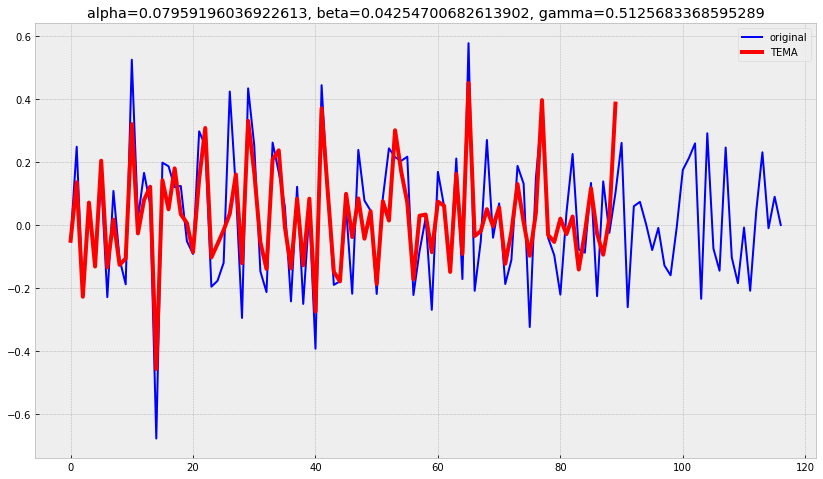

In [110]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=changed_ts[:80], ser_to_plot=changed_ts, n_preds=len(val))

Нестационарный ряд

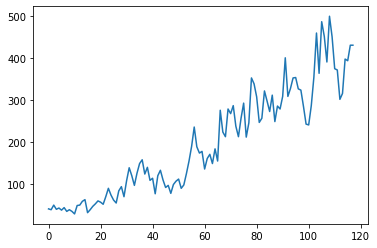

In [111]:
plt.plot(robberies_in_boston['Count'])

In [113]:
train, val, test = robberies_in_boston['Count'][:80], robberies_in_boston['Count'][80:90], robberies_in_boston['Count'][90:]

In [117]:
opt = minimize(mse, x0=[0,0,0], method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

In [118]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

     fun: 4071.285674673192
     jac: array([ -51.60845805, -100.58433873,   17.11123333])
 message: 'Max. number of function evaluations reached'
    nfev: 404
     nit: 19
  status: 3
 success: False
       x: array([0.60559258, 0.01517571, 0.33254888])


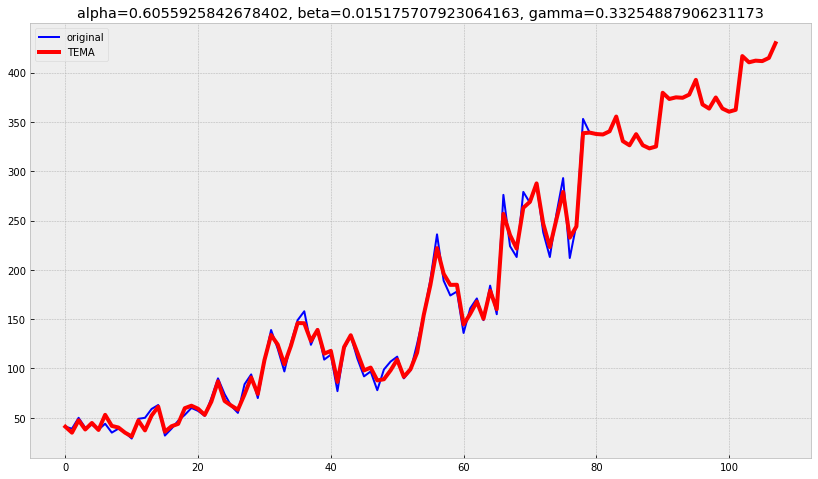

In [120]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=robberies_in_boston['Count'][:80], n_preds=len(test))

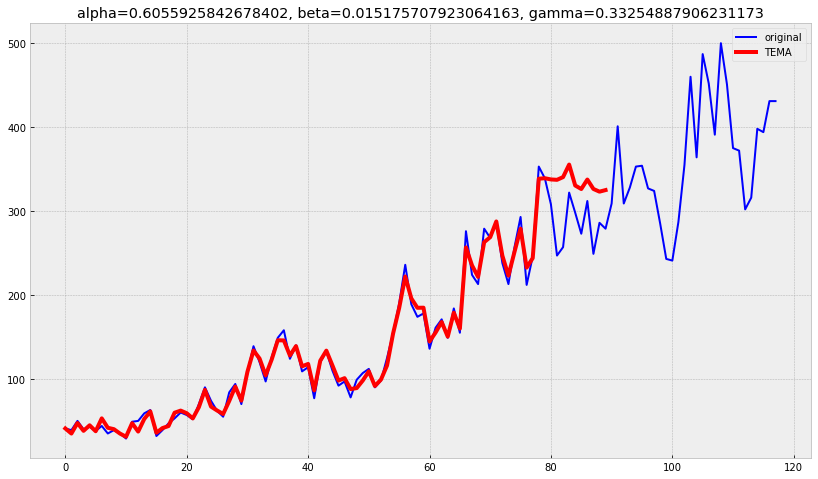

In [122]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=robberies_in_boston['Count'][:80], ser_to_plot=robberies_in_boston['Count'], n_preds=len(val))